In [2]:
import copy
import sys
import os


# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R, lapse_dry
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots, fig_resize, update_fontsize, update_linewidth
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory
from isca_tools.thesis.lapse_theory import interp_var_at_pressure, get_bulk_lapse_rate, reconstruct_temp
from isca_tools import cesm
from isca_tools.convection.base import lcl_metpy
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from geocat.comp.interpolation import interp_hybrid_to_pressure
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

### Load Data

In [96]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['T', 'PS', 'QREFHT', 'TREFHT', 'Z3', 'cape', 'precip', 'cin']
var_isca_dict = {'T': 'temp', 'PS': 'ps', 'QREFHT': 'sphum_2m', 'TREFHT': 'temp_2m', 'Z3': 'height',
                 'cape': 'cape', 'precip': 'precipitation', 'cin': 'cin'}

use_time_start = 3      # ignore the first two years

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
is_isca_data = 'cesm' not in 'exp_dir'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}_6_hours", f"k={str(tau_lw_warm).replace('.','_')}_6_hours"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j], decode_times=True)
        ds_use = ds_use.sel(time=ds_use.time.dt.year >= use_time_start)
        if is_isca_data:
            # Rename isca data to same as for CESM
            ds_use = ds_use[[var_isca_dict[key] for key in var_keep]]
            ds_use = ds_use.rename_vars({v: k for k, v in var_isca_dict.items()})
        else:
            ds_use = ds_use[var_keep]
        ds += [ds_use]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        if j==0:
            p0 = float(namelist['spectral_dynamics_nml']['reference_sea_level_press'])
            sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
            hybm = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
            hyam = np.zeros_like(hybm)
        pbar.update(1)

pfull = ds_use.pfull
n_pressure = ds[0].pfull.size

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [97]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1)
    fig_resize(fig, 3)
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

    if save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf")

In [98]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'


ds_hourly = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory

        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

        if season == 'summer':
            ds_nh_summer = ds_use.sel(time=ds_use.time.dt.month.isin(season_months['nh'])).sel(lat=slice(0, 90))
            ds_sh_summer = ds_use.sel(time=ds_use.time.dt.month.isin(season_months['sh'])).sel(lat=slice(-90, 0))
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        # ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_hourly += [ds_use]
        pbar.update(1)
ds_hourly = xr.concat(ds_hourly, dim=xr.DataArray(tau_lw, dims="kappa", name="kappa"))

  0%|          | 0/2 [00:00<?, ?it/s]

### Average hourly data to get daily values
Here I consider daily, night time and day time values on each day

In [99]:
ds_daily = [ds_hourly.resample(time='1D').mean()]
ds_daily[0] = ds_daily[0].assign_coords(time=ds_daily[0].time.dt.floor('D'))
# Select 3 AM and 3 PM
for hour in [3, 15]:
    ds_daily.append(ds_hourly.sel(time=ds_hourly['time'].dt.hour == hour))
    ds_daily[-1]['time'] = ds_daily[-1].time.dt.floor('D')          # get rid of hourly info in time
ds_daily = xr.concat(ds_daily, dim=xr.DataArray(['av', 'night', 'day'], dims='av_type', name='av_type'))
ds_daily = ds_daily.load()

### Get data conditioned on each quantile of daily average $T_{2m}$

In [100]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant3 is conditioned on percentile of daily average TREFHT
ds_quant3 = []

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        # ds_quant3['TREFHT'][j] = ds_use.TREFHT.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
        ds_j = []
        for k in range(n_lat):
            ds_kj = []
            ds_use = ds_daily.isel(kappa=j, lat=k).load()
            for q, quant in enumerate(quant_plot):
                # get indices corresponding to given near-surface temp quantile
                quant_mask = get_quant_ind(ds_use.sel(av_type='av').TREFHT, quant,
                                           0.5, 0.5, return_mask=True, av_dim=['lon', 'time'])
                ds_kj.append(ds_use.where(quant_mask).mean(dim=['lon', 'time']))
                pbar.update(1)
            ds_j.append(xr.concat(ds_kj, dim=xr.DataArray(quant_plot, dims='quant', name='quant')))
        ds_quant3.append(xr.concat(ds_j, dim='lat'))
ds_quant3 = xr.concat(ds_quant3, dim='kappa')
ds_quant3 = ds_quant3.rename({'pfull': 'lev'})

  0%|          | 0/2772 [00:00<?, ?it/s]

In [102]:
# # Compute T500 and Z500 from pressure info
ds_quant3['T500'] = interp_hybrid_to_pressure(ds_quant3.T, ds_quant3.PS, xr.DataArray(hyam, dims='lev'),
                                              xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(500*100), lev_dim='lev')
ds_quant3['T500'] = ds_quant3['T500'].isel(plev=0).load()
ds_quant3['Z500'] = interp_hybrid_to_pressure(ds_quant3.Z3, ds_quant3.PS, xr.DataArray(hyam, dims='lev'),
                                              xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(500*100), lev_dim='lev')
ds_quant3['Z500'] = ds_quant3['Z500'].isel(plev=0).load()

# Compute RH
ds_quant3['rh_REFHT'] = ds_quant3.QREFHT / sphum_sat(ds_quant3.TREFHT, ds_quant3.PS)

# Compute epsilon = mse_surf - mse_ft_sat
ds_quant3['mse_lapse'] = moist_static_energy(ds_quant3.TREFHT, ds_quant3.QREFHT, 2) - \
                         moist_static_energy(ds_quant3.T500, sphum_sat(ds_quant3.T500, 500 * 100), ds_quant3.Z500)

## Regime change for $x>80$
### $T_{2m}$
The near-surface temperature shows a small diurnal cycle, less than a degree between day and night on average. Interestingly, the average night time temperature is larger than the hottest daytime temperature for the hottest days. This coincides with those days having much less near surface specific humidity as shown in the plot after.

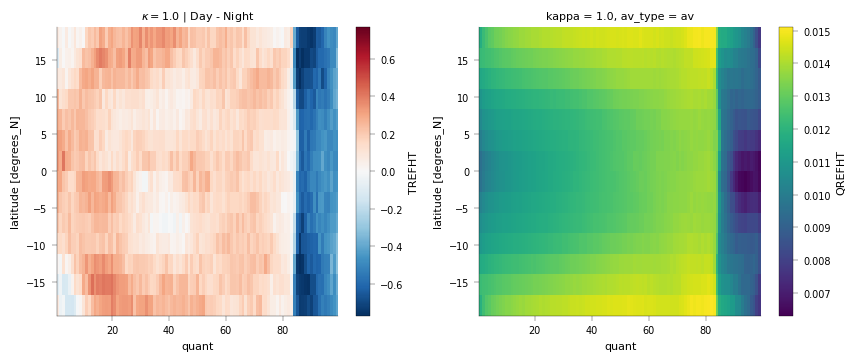

In [106]:
i=0
fig, ax = plt.subplots(1, 2)
fig_resize(fig, 10)
(ds_quant3.TREFHT.sel(av_type='day') - ds_quant3.TREFHT.sel(av_type='night')).isel(kappa=i).plot(ax=ax[0])
ax[0].set_title(f'$\kappa={tau_lw[0]:.1f}$ | Day - Night')
(ds_quant3.QREFHT.sel(av_type='av')).isel(kappa=i).plot(ax=ax[1])
plt.show()

### CAPE and CIN
There seems to be negative daily average CIN in this hot regime as well as larger CAPE.

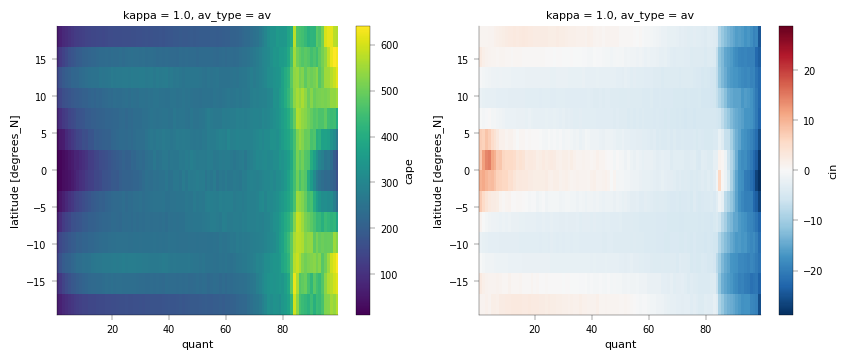

In [120]:
i=0
fig, ax = plt.subplots(1, 2)
fig_resize(fig, 10)
ds_quant3.cape.sel(av_type='av').isel(kappa=i).plot(ax=ax[0])
ds_quant3.cin.sel(av_type='av').isel(kappa=i).plot(ax=ax[1])
plt.show()

### $T$ profile and $T_{500}$
The maximum difference across the entire temperature profile similarly shows quite a small difference between day and night. All this suggests that considering the daily average variables is reasonable. I guess this makes sense as 1m is quite a large mixed layer depth for land.

The value of $T_{500}$ does not show much diurnal cycle as expected, but the value of $T_{500}$ seems to be systematically less for the hottest days.

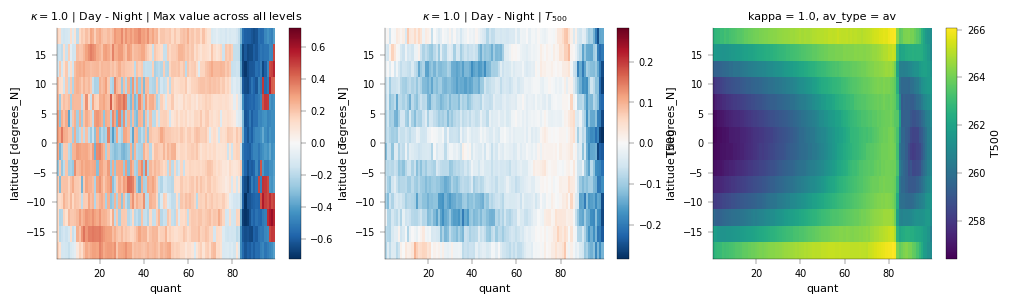

In [133]:
i=0
fig, ax = plt.subplots(1, 3)
fig_resize(fig, 12)
var = (ds_quant3.T.sel(av_type='day') - ds_quant3.T.sel(av_type='night')).isel(kappa=i)
var.sel(lev=abs(var).idxmax(dim='lev')).plot(ax=ax[0])
ax[0].set_title(f'$\kappa={tau_lw[0]:.1f}$ | Day - Night | Max value across all levels')
(ds_quant3.T500.sel(av_type='day') - ds_quant3.T500.sel(av_type='night')).isel(kappa=i).plot(ax=ax[1])
ax[1].set_title(f'$\kappa={tau_lw[0]:.1f}$ | Day - Night | $T_{"{500}"}$')
(ds_quant3.T500.sel(av_type='av')).isel(kappa=i).plot(ax=ax[2])
plt.show()

### Example Temperature profile
The difference between nighttime and daytime temperature profile for a given latitude and quantile is shown below.

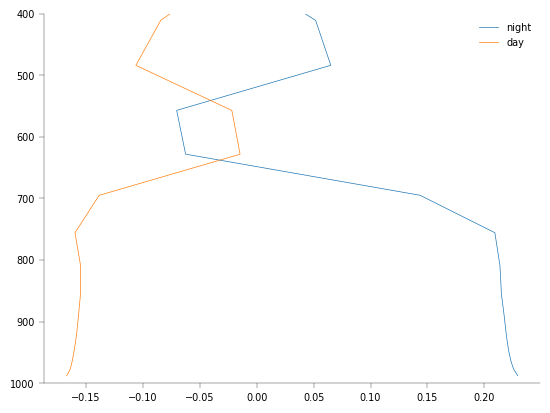

In [91]:
ds_use = ds_quant3.isel(kappa=0, lat=0, quant=98)
for j in range(1, 3):
    plt.plot(ds_use.T[j] - ds_use.T[0], float(ds_use.PS[j]) * hybm/100, color=f'C{j-1}', label=str(ds_use.av_type[j].values))

plt.gca().invert_yaxis()
plt.ylim(1000, 400)
# plt.xlim(300, 315)
plt.legend()

### Profile of all days of given quantile

  0%|          | 0/1152 [00:00<?, ?it/s]

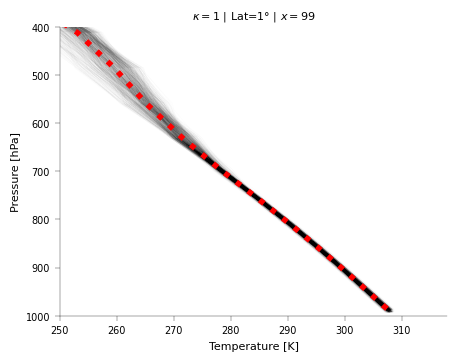

In [335]:
quant_show = 99
lat_show = 1
ds_use = ds_daily.isel(kappa=0).sel(lat=lat_show, method='nearest').load()
# get indices corresponding to given near-surface temp quantile
quant_mask = get_quant_ind(ds_use.sel(av_type='av').TREFHT, quant_show,
                           0.5, 0.5, return_mask=True, av_dim=['lon', 'time'])
ds_use = ds_use.where(quant_mask).load()

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)
with tqdm(total=int(quant_mask.sum()), position=0, leave=True) as pbar:
    for i in range(ds_use.time.size):
        if int(quant_mask.isel(time=i).sum()) == 0:
            continue
        for j in range(ds_use.lon.size):
            if not quant_mask.isel(time=i, lon=j):
                continue
            ax.plot(ds_use.T.isel(time=i, lon=j, av_type=0),
                     float(ds_use.PS.isel(time=i, lon=j, av_type=0)) * hybm/100, color='k', alpha=0.01)
            pbar.update(1)
ax.plot(ds_quant3.isel(kappa=0).sel(quant=quant_show, av_type='av').sel(lat=lat_show, method='nearest').T,
        float(ds_quant3.isel(kappa=0).sel(quant=quant_show, av_type='av').sel(lat=lat_show, method='nearest').PS) * hybm/100,
        color='r', linestyle=':', lw=4)
ax.invert_yaxis()
ax.set_ylim(1000, 400)
ax.set_xlim(250, 318)
ax.set_title(f'$\kappa={ds_use.kappa:.0f}$ | Lat={ds_use.lat:.0f}$\degree$ | $x={quant_show}$')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [hPa]')
plt.show()

### Show some consecutive days
Show profile for some consecutive days of a given latitude, quantile and longitude.

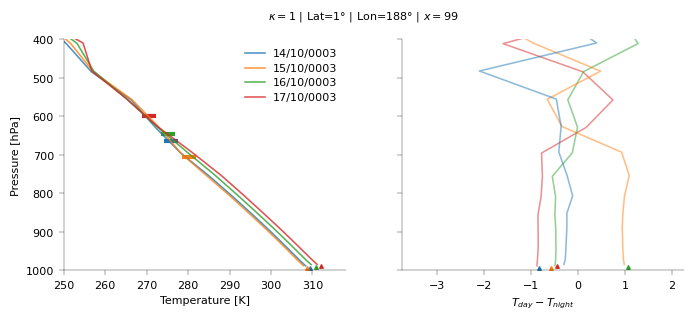

In [337]:
ds_use = ds_daily.isel(kappa=0).sel(lat=lat_show, method='nearest').load()
quant_show = 99
# get indices corresponding to given near-surface temp quantile
quant_mask = get_quant_ind(ds_use.sel(av_type='av').TREFHT, quant_show,
                           0.5, 0.5, return_mask=True, av_dim=['lon', 'time'])
lon_ind_use = int(quant_mask.sum(dim='time').argmax())              # choose longitude with most hot days
ds_use = ds_use.isel(lon=lon_ind_use)
days_show = 4
time_show_ind = int(ds_use.TREFHT.sel(av_type='av').argmax())

fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 8)
for i in range(days_show)[::-1]:
    label_use = f"{ds_use.isel(time=time_show_ind-i).time.dt.day:.0f}/{ds_use.isel(time=time_show_ind-i).time.dt.month:.0f}/{ds_use.isel(time=time_show_ind-i, av_type=0).time.dt.year:04}"
    ax[0].plot(ds_use.T.isel(time=time_show_ind-i, av_type=0),
            float(ds_use.PS.isel(time=time_show_ind-i, av_type=0)) * hybm/100, color=f'C{days_show-i-1}', alpha=0.8, label=label_use)
    ax[0].scatter(ds_use.TREFHT.isel(time=time_show_ind-i, av_type=0), float(ds_use.PS.isel(time=time_show_ind-i, av_type=0))/100,
                  color=f'C{days_show-i-1}', marker='^')
    p_lcl_use, T_lcl_use = lcl_metpy(ds_use.TREFHT.isel(time=time_show_ind-i, av_type=0),
                                     ds_use.QREFHT.isel(time=time_show_ind-i, av_type=0), ds_use.PS.isel(time=time_show_ind-i, av_type=0))
    ax[0].scatter(T_lcl_use, p_lcl_use/100, color=f'C{days_show-i-1}', marker='_', s=100, lw=3)

    ax[1].plot(ds_use.T.isel(time=time_show_ind-i, av_type=2) - ds_use.T.isel(time=time_show_ind-i, av_type=1),
        float(ds_use.PS.isel(time=time_show_ind-i, av_type=0)) * hybm/100, color=f'C{i}', alpha=0.5)
    ax[1].scatter(ds_use.TREFHT.isel(time=time_show_ind-i, av_type=2)-ds_use.TREFHT.isel(time=time_show_ind-i, av_type=1),
                  float(ds_use.PS.isel(time=time_show_ind-i, av_type=0))/100,
                  color=f'C{days_show-i-1}', marker='^')
ax[0].invert_yaxis()
update_linewidth(fig)
ax[0].legend()
ax[0].set_ylim(1000, 400)
ax[0].set_xlim(250, 318)
fig.suptitle(f'$\kappa={ds_use.kappa:.0f}$ | Lat={ds_use.lat:.0f}$\degree$ | Lon={ds_use.lon:.0f}$\degree$ | $x={quant_show}$')
ax[0].set_xlabel('Temperature [K]')
ax[0].set_ylabel('Pressure [hPa]')
ax[1].set_xlabel('$T_{day} - T_{night}$')
update_fontsize(fig, base_fontsize=7)
plt.show()